# **Pix2Pix**

* Mateo Cano Solis
* Keyla Jeaneth Garcia Jaimes

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
root_dir = "/content/drive/My Drive/"
personal_dir = 'deep_learning/pix2pix/'  ###DEFINE TU DIRECTORIO EN DRIVE QUE CONTIENE LA BASE DE ENTRENAMIENTO (DONDE ESTA LA CARPETA TRAIN_ORIGINAL) ####
base_dir = root_dir + personal_dir
print(base_dir)

/content/drive/My Drive/deep_learning/pix2pix/


In [7]:
# example of pix2pix gan for satellite to map image-to-image translation
# Creation of Unet encoder and decoder generator, and conditional discriminator

from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

from os import listdir
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
print("Todas las librerias se han importado con éxito")



Todas las librerias se han importado con éxito


In [8]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = base_dir + 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = base_dir + 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))




In [9]:

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=50, n_batch=1):
  # determine the output square shape of the discriminator
  n_patch = d_model.output_shape[1]
  # unpack dataset
  trainA, trainB = dataset
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  for i in range(n_steps):
    # select a batch of real samples
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
    # generate a batch of fake samples
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
    # update discriminator for real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    # update discriminator for generated samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    # update the generator
    g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
    # summarize performance
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    # summarize model performance
    """
    if (i+1) % (bat_per_epo * 10) == 0:
      summarize_performance(i, g_model, dataset)
    """
    if (i+1) % len(trainA) == 0:
      #Summarize performance
      summarize_performance(i/len(trainA), g_model, dataset)

In [19]:
import os
# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for file_name in listdir(path):
		# load and resize the image
		pixels = load_img(path + file_name, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		map_img, sat_img = pixels[:, :256], pixels[:, 256:]   # Please put an eye on this !
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

# dataset path
#path = os.path.join(base_dir + "train_original/")
path = os.path.join(base_dir)
# load dataset
print("El directorio del dataset es: ",path)
[src_images, tar_images] = load_images(path )
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = os.path.join(base_dir, 'maps_256.npz')
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

El directorio del dataset es:  /content/drive/My Drive/deep_learning/pix2pix/
Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)
Saved dataset:  /content/drive/My Drive/deep_learning/pix2pix/maps_256.npz


Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


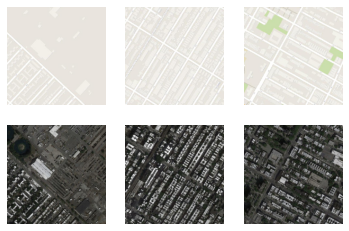

In [20]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load(filename)
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

Define el número de épocas a entrenar

In [22]:
n_epochs = 10

In [21]:
base_dir

'/content/drive/My Drive/deep_learning/pix2pix/'

In [23]:
# load image data
dataset = load_real_samples(base_dir + 'maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset,n_epochs = n_epochs)

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, d1[0.236] d2[1.155] g[66.171]
>2, d1[0.271] d2[0.947] g[60.896]
>3, d1[0.250] d2[0.613] g[44.458]
>4, d1[0.338] d2[0.399] g[43.205]
>5, d1[0.365] d2[0.287] g[44.625]
>6, d1[0.426] d2[0.237] g[70.657]
>7, d1[0.319] d2[0.469] g[41.518]
>8, d1[0.330] d2[0.405] g[46.593]
>9, d1[0.403] d2[0.179] g[41.363]
>10, d1[0.346] d2[0.184] g[36.758]
>11, d1[0.277] d2[0.145] g[33.416]
>12, d1[0.177] d2[0.252] g[43.516]
>13, d1[0.414] d2[0.138] g[26.554]
>14, d1[0.170] d2[0.258] g[36.639]
>15, d1[0.293] d2[0.109] g[30.588]
>16, d1[0.263] d2[0.071] g[29.733]
>17, d1[0.094] d2[0.513] g[27.843]
>18, d1[0.493] d2[1.112] g[22.053]
>19, d1[0.336] d2[0.401] g[24.509]
>20, d1[0.322] d2[0.104] g[25.355]
>21, d1[0.277] d2[0.166] g[29.575]
>22, d1[0.223] d2[0.095] g[23.636]
>23, d1[0.169] d2[0.097] g[22.077]
>24, d1[0.116] d2[0.031] g[26.751]
>25, d1[0.106] d2[0.028] g[31.481]
>26, d1[0.092] d2[0.036] g[22.195]
>27, d1[0.064] d2[0.042] g[29.165]
>28, d1[0.069] d2[0.063] g[25.542]
>29, d1[0.069] d2[0.033] g[23

>Saved: /content/drive/My Drive/deep_learning/pix2pix/plot_000001.png and /content/drive/My Drive/deep_learning/pix2pix/model_000001.h5
>1097, d1[0.012] d2[0.016] g[21.982]
>1098, d1[0.002] d2[0.013] g[20.773]
>1099, d1[0.004] d2[0.010] g[19.271]
>1100, d1[0.001] d2[0.009] g[27.966]
>1101, d1[0.001] d2[0.008] g[22.571]
>1102, d1[0.000] d2[0.014] g[24.354]
>1103, d1[0.004] d2[0.085] g[18.134]
>1104, d1[0.001] d2[0.007] g[23.686]
>1105, d1[0.003] d2[0.011] g[24.263]
>1106, d1[0.003] d2[0.005] g[19.867]
>1107, d1[0.000] d2[0.005] g[28.054]
>1108, d1[0.001] d2[0.004] g[22.368]
>1109, d1[0.001] d2[0.007] g[24.795]
>1110, d1[0.005] d2[0.015] g[23.117]
>1111, d1[0.002] d2[0.007] g[20.882]
>1112, d1[0.000] d2[0.007] g[27.675]
>1113, d1[0.003] d2[0.007] g[20.047]
>1114, d1[0.001] d2[0.020] g[23.744]
>1115, d1[0.700] d2[0.035] g[6.474]
>1116, d1[0.001] d2[1.072] g[17.292]
>1117, d1[0.001] d2[0.004] g[27.627]
>1118, d1[0.288] d2[0.284] g[11.966]
>1119, d1[0.002] d2[0.005] g[21.754]
>1120, d1[0.00

>Saved: /content/drive/My Drive/deep_learning/pix2pix/plot_000002.png and /content/drive/My Drive/deep_learning/pix2pix/model_000002.h5
>2193, d1[0.009] d2[0.002] g[21.345]
>2194, d1[0.003] d2[0.002] g[26.385]
>2195, d1[0.022] d2[0.002] g[19.952]
>2196, d1[0.008] d2[0.005] g[19.758]
>2197, d1[0.024] d2[0.004] g[20.753]
>2198, d1[0.001] d2[0.002] g[23.946]
>2199, d1[0.006] d2[0.003] g[21.938]
>2200, d1[0.009] d2[0.001] g[19.625]
>2201, d1[0.001] d2[0.002] g[22.137]
>2202, d1[0.001] d2[0.001] g[22.024]
>2203, d1[0.001] d2[0.001] g[23.044]
>2204, d1[2.322] d2[0.053] g[2.686]
>2205, d1[0.001] d2[0.086] g[17.813]
>2206, d1[0.000] d2[0.028] g[20.513]
>2207, d1[0.000] d2[0.029] g[23.963]
>2208, d1[0.000] d2[0.044] g[15.160]
>2209, d1[0.000] d2[0.011] g[25.132]
>2210, d1[0.000] d2[0.005] g[21.357]
>2211, d1[0.177] d2[0.143] g[17.149]
>2212, d1[0.001] d2[0.013] g[13.565]
>2213, d1[0.001] d2[0.009] g[30.819]
>2214, d1[0.877] d2[0.250] g[3.422]
>2215, d1[0.168] d2[0.160] g[5.962]
>2216, d1[0.000]

>Saved: /content/drive/My Drive/deep_learning/pix2pix/plot_000003.png and /content/drive/My Drive/deep_learning/pix2pix/model_000003.h5
>3289, d1[0.225] d2[0.002] g[14.529]
>3290, d1[0.000] d2[0.018] g[26.124]
>3291, d1[0.000] d2[0.004] g[21.303]
>3292, d1[0.001] d2[0.001] g[23.357]
>3293, d1[0.010] d2[0.001] g[21.758]
>3294, d1[0.001] d2[0.002] g[18.341]
>3295, d1[0.001] d2[0.009] g[17.574]
>3296, d1[0.000] d2[0.005] g[21.875]
>3297, d1[0.000] d2[0.003] g[24.757]
>3298, d1[0.000] d2[0.002] g[28.198]
>3299, d1[0.001] d2[0.007] g[20.492]
>3300, d1[0.483] d2[0.496] g[2.410]
>3301, d1[0.006] d2[0.161] g[11.412]
>3302, d1[0.000] d2[0.004] g[28.068]
>3303, d1[0.001] d2[0.001] g[23.213]
>3304, d1[0.209] d2[0.241] g[14.353]
>3305, d1[0.001] d2[0.002] g[22.926]
>3306, d1[0.001] d2[0.002] g[25.446]
>3307, d1[0.001] d2[0.002] g[26.179]
>3308, d1[0.014] d2[0.003] g[19.502]
>3309, d1[0.002] d2[0.003] g[22.221]
>3310, d1[0.002] d2[0.010] g[18.718]
>3311, d1[0.349] d2[0.017] g[8.907]
>3312, d1[0.000

>Saved: /content/drive/My Drive/deep_learning/pix2pix/plot_000004.png and /content/drive/My Drive/deep_learning/pix2pix/model_000004.h5
>4385, d1[0.017] d2[0.035] g[12.503]
>4386, d1[0.001] d2[0.001] g[23.508]
>4387, d1[0.002] d2[0.001] g[22.797]
>4388, d1[0.001] d2[0.001] g[20.166]
>4389, d1[0.002] d2[0.001] g[19.740]
>4390, d1[0.068] d2[0.000] g[18.085]
>4391, d1[0.001] d2[0.001] g[18.393]
>4392, d1[0.001] d2[0.019] g[13.334]
>4393, d1[0.002] d2[0.001] g[13.435]
>4394, d1[0.001] d2[0.000] g[32.546]
>4395, d1[0.001] d2[0.003] g[22.263]
>4396, d1[0.000] d2[0.000] g[28.083]
>4397, d1[0.000] d2[0.001] g[24.708]
>4398, d1[0.001] d2[0.001] g[22.993]
>4399, d1[0.001] d2[0.003] g[29.186]
>4400, d1[0.000] d2[0.003] g[19.104]
>4401, d1[0.094] d2[0.002] g[12.550]
>4402, d1[0.000] d2[0.049] g[23.451]
>4403, d1[0.001] d2[0.000] g[13.871]
>4404, d1[0.000] d2[0.042] g[27.673]
>4405, d1[0.002] d2[0.000] g[12.982]
>4406, d1[0.000] d2[0.002] g[29.024]
>4407, d1[0.000] d2[0.001] g[28.886]
>4408, d1[0.0

>Saved: /content/drive/My Drive/deep_learning/pix2pix/plot_000005.png and /content/drive/My Drive/deep_learning/pix2pix/model_000005.h5
>5481, d1[0.000] d2[0.004] g[20.580]
>5482, d1[0.000] d2[0.002] g[23.892]
>5483, d1[0.001] d2[0.013] g[16.486]
>5484, d1[0.000] d2[0.002] g[27.134]
>5485, d1[0.000] d2[0.001] g[19.474]
>5486, d1[0.000] d2[0.270] g[16.217]
>5487, d1[0.000] d2[0.000] g[27.671]
>5488, d1[0.000] d2[0.000] g[26.932]
>5489, d1[0.000] d2[0.000] g[22.452]
>5490, d1[0.001] d2[0.002] g[19.332]
>5491, d1[0.007] d2[0.000] g[18.427]
>5492, d1[0.008] d2[0.002] g[19.341]
>5493, d1[0.000] d2[0.001] g[20.690]
>5494, d1[0.000] d2[0.000] g[22.743]
>5495, d1[0.000] d2[0.000] g[22.775]
>5496, d1[0.000] d2[0.001] g[20.786]
>5497, d1[0.002] d2[0.007] g[11.554]
>5498, d1[0.000] d2[0.000] g[21.903]
>5499, d1[0.000] d2[0.001] g[22.096]
>5500, d1[0.000] d2[0.000] g[19.058]
>5501, d1[0.000] d2[0.000] g[22.114]
>5502, d1[0.006] d2[0.002] g[16.618]
>5503, d1[0.000] d2[0.000] g[23.451]
>5504, d1[0.0

>Saved: /content/drive/My Drive/deep_learning/pix2pix/plot_000006.png and /content/drive/My Drive/deep_learning/pix2pix/model_000006.h5
>6577, d1[0.000] d2[0.000] g[19.875]
>6578, d1[0.000] d2[0.000] g[22.402]
>6579, d1[0.000] d2[0.000] g[18.610]
>6580, d1[0.000] d2[0.000] g[18.885]
>6581, d1[0.000] d2[0.000] g[18.903]
>6582, d1[0.000] d2[0.000] g[22.093]
>6583, d1[0.000] d2[0.001] g[25.074]
>6584, d1[0.000] d2[0.000] g[24.618]
>6585, d1[0.002] d2[0.002] g[8.134]
>6586, d1[0.000] d2[0.001] g[19.581]
>6587, d1[0.000] d2[0.001] g[11.119]
>6588, d1[0.003] d2[0.001] g[16.730]
>6589, d1[0.000] d2[0.000] g[17.028]
>6590, d1[0.000] d2[0.000] g[18.409]
>6591, d1[0.000] d2[0.000] g[22.976]
>6592, d1[0.000] d2[0.000] g[17.467]
>6593, d1[0.000] d2[0.001] g[15.620]
>6594, d1[0.000] d2[0.000] g[25.008]
>6595, d1[0.000] d2[0.001] g[24.644]
>6596, d1[0.000] d2[0.005] g[9.723]
>6597, d1[0.000] d2[0.000] g[26.853]
>6598, d1[0.000] d2[0.000] g[23.076]
>6599, d1[0.000] d2[0.001] g[21.879]
>6600, d1[0.000

>Saved: /content/drive/My Drive/deep_learning/pix2pix/plot_000007.png and /content/drive/My Drive/deep_learning/pix2pix/model_000007.h5
>7673, d1[0.000] d2[0.000] g[24.558]
>7674, d1[0.000] d2[0.000] g[22.064]
>7675, d1[0.000] d2[0.000] g[18.760]
>7676, d1[0.000] d2[0.000] g[24.154]
>7677, d1[0.001] d2[0.000] g[14.714]
>7678, d1[0.000] d2[0.000] g[26.698]
>7679, d1[0.000] d2[0.000] g[11.983]
>7680, d1[0.000] d2[0.000] g[19.019]
>7681, d1[0.000] d2[0.000] g[23.670]
>7682, d1[0.000] d2[0.000] g[21.123]
>7683, d1[0.000] d2[0.000] g[5.871]
>7684, d1[0.000] d2[0.000] g[16.172]
>7685, d1[0.000] d2[0.000] g[15.389]
>7686, d1[0.000] d2[0.000] g[20.363]
>7687, d1[0.000] d2[0.000] g[20.893]
>7688, d1[0.000] d2[0.000] g[19.786]
>7689, d1[0.000] d2[0.000] g[18.474]
>7690, d1[0.000] d2[0.000] g[20.276]
>7691, d1[0.000] d2[0.000] g[27.236]
>7692, d1[0.000] d2[0.000] g[17.787]
>7693, d1[0.000] d2[0.001] g[23.078]
>7694, d1[0.000] d2[0.000] g[23.118]
>7695, d1[0.000] d2[0.000] g[16.153]
>7696, d1[0.00

>Saved: /content/drive/My Drive/deep_learning/pix2pix/plot_000008.png and /content/drive/My Drive/deep_learning/pix2pix/model_000008.h5
>8769, d1[0.001] d2[0.000] g[15.957]
>8770, d1[0.000] d2[0.000] g[23.401]
>8771, d1[0.000] d2[0.000] g[25.146]
>8772, d1[0.000] d2[0.000] g[23.889]
>8773, d1[0.000] d2[0.000] g[13.957]
>8774, d1[0.000] d2[0.000] g[11.853]
>8775, d1[0.000] d2[0.000] g[18.822]
>8776, d1[0.000] d2[0.000] g[23.724]
>8777, d1[0.001] d2[0.000] g[7.614]
>8778, d1[0.000] d2[0.000] g[24.861]
>8779, d1[0.000] d2[0.000] g[10.746]
>8780, d1[0.000] d2[0.000] g[16.522]
>8781, d1[0.000] d2[0.000] g[12.419]
>8782, d1[0.001] d2[0.000] g[21.202]
>8783, d1[0.000] d2[0.000] g[26.829]
>8784, d1[0.000] d2[0.006] g[22.120]
>8785, d1[0.000] d2[0.000] g[21.700]
>8786, d1[0.000] d2[0.000] g[22.451]
>8787, d1[0.000] d2[0.000] g[10.382]
>8788, d1[0.000] d2[0.000] g[26.614]
>8789, d1[0.000] d2[0.000] g[12.867]
>8790, d1[0.000] d2[0.000] g[22.488]
>8791, d1[0.001] d2[0.000] g[10.076]
>8792, d1[0.00

>Saved: /content/drive/My Drive/deep_learning/pix2pix/plot_000009.png and /content/drive/My Drive/deep_learning/pix2pix/model_000009.h5
>9865, d1[0.000] d2[0.000] g[14.141]
>9866, d1[0.000] d2[0.000] g[16.285]
>9867, d1[0.000] d2[0.000] g[22.404]
>9868, d1[0.000] d2[0.000] g[9.502]
>9869, d1[0.000] d2[0.000] g[22.394]
>9870, d1[0.000] d2[0.000] g[17.736]
>9871, d1[0.000] d2[0.000] g[21.090]
>9872, d1[0.000] d2[0.000] g[6.581]
>9873, d1[0.000] d2[0.000] g[12.421]
>9874, d1[0.000] d2[0.000] g[15.336]
>9875, d1[0.000] d2[0.000] g[18.999]
>9876, d1[0.000] d2[0.000] g[17.850]
>9877, d1[0.000] d2[0.000] g[25.199]
>9878, d1[0.000] d2[0.000] g[13.009]
>9879, d1[0.000] d2[0.000] g[22.173]
>9880, d1[0.000] d2[0.000] g[11.291]
>9881, d1[0.000] d2[0.000] g[20.936]
>9882, d1[0.000] d2[0.000] g[26.284]
>9883, d1[0.000] d2[0.000] g[25.019]
>9884, d1[0.000] d2[0.000] g[6.875]
>9885, d1[0.000] d2[0.000] g[17.177]
>9886, d1[0.000] d2[0.000] g[21.941]
>9887, d1[0.000] d2[0.000] g[24.035]
>9888, d1[0.000]

>Saved: /content/drive/My Drive/deep_learning/pix2pix/plot_000010.png and /content/drive/My Drive/deep_learning/pix2pix/model_000010.h5


In [24]:
# make an animation gif of the training results every 10 epochs
import imageio

images=[]
for file_name in sorted(os.listdir(base_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(base_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave(os.path.join(base_dir, 'epochs_animation_10.gif'), images, duration=2, loop=3)
print('Animation ready, please pick the best generator model!')

Animation ready, please pick the best generator model!


## **Modelo con 10 epocas**

A pesar de que la recomendación era correr el modelo con 50, 100 o 150 epocas, este es sumamente pesado y con tan solo 10 epocas llego a los 33 minutos de ejecución.

Sin embargo, con este número de epocas podemos evidenciar el gran potencial que posee el modelo para "traducir" o generar imagenes, con una gran precisión. En este caso se corrio el modelo en dirección contraria, de mapas a satelites, adquiriendo excelentes resultados. 

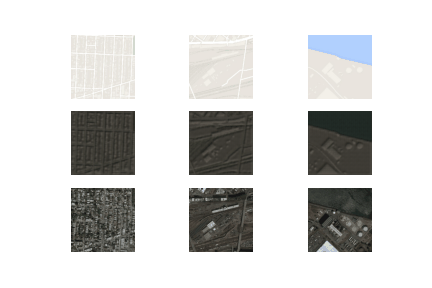

### **Predicción para Medellín**

In [26]:
import osr
import gdal
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import load
from numpy import expand_dims
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import geopandas as gp
from pathlib import Path
import os
from PIL import Image
from skimage.morphology import skeletonize, thin
from skimage.io import imread
from skimage.io import imsave

In [25]:
# load an image
def load_image(myfile, size=(256,256)):
    # load image with the preferred size
    pixels = load_img(myfile, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # scale from [0,255] to [-1,1] las gans trabajan centradas en el origen
    pixels = (pixels - 127.5) / 127.5
    # reshape to 1 sample
    pixels = expand_dims(pixels, 0)  # pasa el canal para adelante
    return pixels

In [28]:
tile_width = 256
tile_height = 256


modelname = 'model_000010.h5'
model = load_model(base_dir + modelname, compile=False)

(-0.5, 255.5, 255.5, -0.5)

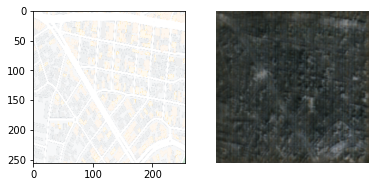

In [32]:
img_name = 'Medellin2.jpg'
raster_path = base_dir + img_name

size=(256,256)
myimg = load_img(raster_path, target_size=size, color_mode='rgb')
img = load_image(raster_path)
res_img = model.predict(img)
# Imagen resultante se vuelve al intervalo [0,1]
res_img = (res_img + 1) / 2.0

#mpimg.imsave(raster_out_folder_name + "11predict.png", res_img[0])

#plt.imshow(img[0])
#plt.axis('off')
#plt.show()

#plt.imshow(res_img[0])
#plt.axis('off')
#plt.show()

#print(data_masks_path/img_name)

fig, ax = plt.subplots(1,2)
ax[0].imshow(myimg);
plt.axis('off')
ax[1].imshow(res_img[0]);
plt.axis('off')

Evidentemente la falta de entrenamiento no permite determinar unas capas mucho más definida en la imagen satelital, sin embargo la imagen satelital se ve texturizada con las lineas más fuertes como la diagonal, al entrenar para más epocas seguramente se lograran mejores resultados en este modelo de pix2pix

## **Otras Aplicaciones**

* To convert pixel level segmentation into real images
* To convert day images into night images and vice versa
* To convert satellite areal images into map images
* To convert sketches into photos
* To convert black and white images into colored images and vice versa